In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import seaborn as sns
import datetime
from matplotlib import pyplot as plt
from pymongo import MongoClient

from IPython.core.display import display, HTML
from jupyterthemes import jtplot
jtplot.style('onedork')

np.warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:.2f}'.format
display(HTML("<style>.container { width: 1480px !important; }</style>"))

def preprocess(data):
    data['datetime'] = pd.to_datetime(data['TIME_DHAKA'], format='%d/%m/%y %H:%M:%S')
    data['date'] = data['datetime'].dt.date
    data['year'] = data['datetime'].dt.year
    data['month'] = data['datetime'].dt.month
    data['week'] = data['datetime'].dt.week
    data['weekday'] = data['datetime'].dt.weekday
    data['day'] = data['datetime'].dt.day
    data['hour'] = data['datetime'].dt.hour
    data = data.set_index(['solbox_id', 'datetime']).sort_index()
    currents = ['fILoadDirect_avg', 'fILoad_avg', 'fIPV_avg', 'fIExcess_avg', 'fIToGrid_avg', 'fIToBat_avg']
    for v in currents:
        try:
            data[v] = data[v].apply(lambda x: x.replace(',', '.')).astype(float)
            data[v] = data.groupby(['solbox_id'])[v].apply(remove_outliers_lambda).ffill().fillna(0)
        except AttributeError:
            data[v] = data[v].apply(lambda x: x.replace(',', '.') if isinstance(x, str) else x).astype(float)
            data[v] = data.groupby(['solbox_id'])[v].apply(remove_outliers_lambda).ffill()
    print(data.columns)
    date_cols = ['year', 'month', 'week', 'weekday', 'day', 'hour']
    other_cols = ['u8UserMode', 'u8StateOfBattery', 'u32TotalBought', 'u32TotalSold', 'fBuyPrice', 'fSellPrice'] 
    cols_to_keep = currents + date_cols + other_cols
    return data[cols_to_keep]

def group_data_hourly(data):
    data_hourly = data.groupby(['solbox_id', 'year', 'month', 'day', 'hour']).mean().reset_index()
    data_hourly['datetime'] = data_hourly.apply(lambda x: datetime.datetime(int(x['year']), int(x['month']), int(x['day']), int(x['hour'])), axis=1)
    data_hourly = data_hourly.set_index(['solbox_id', 'datetime'])
    return data

def read_data_csv(path='../data/bengutari.csv', nrows=None):
    data = pd.read_csv(path, nrows=nrows)

def get_station_ids(coll):
    return list(coll.distinct('solbox_id'))

def load_single_station(coll, station_id, nrows=None):
    return pd.DataFrame(list(coll.find({'solbox_id': station_id}).limit(nrows)))

def load_all_stations(coll, nrows=None):
    return pd.DataFrame(list(coll.find().limit(nrows)))

def load_all_stations_first_n(coll, nrows=None):
    data = list()
    for station in get_station_ids(coll):
        data.append(load_single_station(coll, station, nrows))
    
    return pd.concat(data)

def insert_many(data, coll):
    coll.insert_many(data.to_dict('records'))
    
def remove_outliers_lambda(data, formula=lambda x: x > (max(np.percentile(x, 75), 0)*3)):
    data.loc[formula(data)] = np.nan
    return data

In [2]:
%%time
client = MongoClient(host='127.0.0.1', port=27017)
db = client['energy']

currents = ['fILoadDirect_avg', 'fILoad_avg', 'fIPV_avg', 'fIExcess_avg', 'fIToGrid_avg', 'fIToBat_avg']
stations = data.index.get_level_values(0).unique()

data = load_all_stations_first_n(db.measurements, int(1e10))
data = preprocess(data)
stations = list(data.index.get_level_values(0).unique())

Index(['EE/(SG+Bat)', 'EE/SG', 'E_Excess', 'E_Excess_1', 'E_Load',
       'E_LoadDirect', 'E_LoadDirect_1', 'E_Load_1', 'E_PV', 'E_PV_1',
       'E_toBat', 'E_toBat_1', 'E_toGrid', 'E_toGrid +', 'E_toGrid -', 'IE/SC',
       'SolBox', 'TE_Excess', 'TE_Load', 'TE_LoadDirect', 'TE_PV', 'TE_toBat',
       'TE_toGrid +', 'TE_toGrid -', 'TIME_DHAKA', '_id', 'fBalance_Tk',
       'fBuyPrice', 'fDutyCycleDCDC_avg', 'fDutyCyclePV_avg', 'fIExcess_avg',
       'fILoadDirect_avg', 'fILoad_avg', 'fIPV_avg', 'fIToBat_avg',
       'fIToGrid_avg', 'fPExcess_avg', 'fPGeneration_avg', 'fPLoad_avg',
       'fPLoad_direct_avg', 'fSellPrice', 'fTemperature_avg',
       'fTotal_bought_Ah', 'fTotal_bought_Ah_fixed_tariff', 'fTotal_bought_Tk',
       'fTotal_sold_Ah', 'fTotal_sold_Ah_fixed_tariff', 'fTotal_sold_Tk',
       'fVBattery_avg', 'fVGrid_avg', 'fVPV_avg', 'fVRef_avg', 'i32Balance',
       'out_of_range', 'rssi', 'u32Error', 'u32Grid_mode', 'u32Load_mode',
       'u32OperationMode', 'u32PV_mode', 'u

In [3]:
print(data.shape)
data.head()

(1186431, 18)


fILoadDirect_avg  fILoad_avg  fIPV_avg  \
solbox_id datetime                                                      
30        2017-10-30 06:02:24             34.80       69.21     13.26   
          2017-10-30 06:04:26             34.83       69.01     13.12   
          2017-10-30 06:06:31             34.82       68.85     13.06   
          2017-10-30 06:08:34             34.87       70.60     13.59   
          2017-10-30 06:10:29             34.94       71.49     13.80   

                               fIExcess_avg  fIToGrid_avg  fIToBat_avg  year  \
solbox_id datetime                                                             
30        2017-10-30 06:02:24          0.00          5.12       -61.06  2017   
          2017-10-30 06:04:26          0.00          5.05       -60.93  2017   
          2017-10-30 06:06:31          0.00          5.01       -60.80  2017   
          2017-10-30 06:08:34          0.00          5.49       -62.49  2017   
          2017-10-30 06:10:29          0.00          5.64       -63.34  2017   

                               month  week  weekday  day  hour  u8UserMode  \
solbox_id datetime                                                           
30        2017-10-30 06:02:24     10    44        0   30     6           0   
          2017-10-30 06:04:26     10    44        0   30     6           0   
          2017-10-30 06:06:31     10    44        0   30     6           0   
          2017-10-30 06:08:34     10    44        0   30     6           0   
          2017-10-30 06:10:29     10    44        0   30     6           0   

                               u8StateOfBattery  u32TotalBought  u32TotalSold  \
solbox_id datetime                                                              
30        2017-10-30 06:02:24                 3            1186         64891   
          2017-10-30 06:04:26                 3            1186         64891   
          2017-10-30 06:06:31                 3            1186         64891   
          2017-10-30 06:08:34                 3            1186         64891   
          2017-10-30 06:10:29                 3            1186         64891   

                              fBuyPrice fSellPrice  
solbox_id datetime                                  
30        2017-10-30 06:02:24      1,92        1,2  
          2017-10-30 06:04:26      1,92        1,2  
          2017-10-30 06:06:31      1,92        1,2  
          2017-10-30 06:08:34      1,92        1,2  
          2017-10-30 06:10:29      1,92        1,2

In [4]:
data_hourly = group_data_hourly(data)
print(data_hourly.shape)
data_hourly.head()

(44462, 16)


year  month  day  hour  fILoadDirect_avg  \
solbox_id datetime                                                        
30        2017-10-30 06:00:00  2017     10   30     6             34.91   
          2017-10-30 07:00:00  2017     10   30     7             34.89   
          2017-10-30 08:00:00  2017     10   30     8             34.80   
          2017-10-30 09:00:00  2017     10   30     9             34.65   
          2017-10-30 10:00:00  2017     10   30    10             34.47   

                               fILoad_avg  fIPV_avg  fIExcess_avg  \
solbox_id datetime                                                  
30        2017-10-30 06:00:00       70.00     13.49          0.00   
          2017-10-30 07:00:00       71.14     15.96          0.00   
          2017-10-30 08:00:00       71.57     14.54          0.00   
          2017-10-30 09:00:00       72.05     14.88          0.00   
          2017-10-30 10:00:00       72.16     15.14          0.00   

                               fIToGrid_avg  fIToBat_avg  week  weekday  \
solbox_id datetime                                                        
30        2017-10-30 06:00:00          5.33       -61.84 44.00     0.00   
          2017-10-30 07:00:00          5.27       -60.46 44.00     0.00   
          2017-10-30 08:00:00          5.49       -62.51 44.00     0.00   
          2017-10-30 09:00:00          5.56       -62.73 44.00     0.00   
          2017-10-30 10:00:00          5.86       -62.88 44.00     0.00   

                               u8UserMode  u8StateOfBattery  u32TotalBought  \
solbox_id datetime                                                            
30        2017-10-30 06:00:00        0.00              3.00         1186.00   
          2017-10-30 07:00:00        0.00              3.00         1186.00   
          2017-10-30 08:00:00        0.00              3.00         1186.00   
          2017-10-30 09:00:00        0.00              3.00         1186.00   
          2017-10-30 10:00:00        0.00              3.00         1186.00   

                               u32TotalSold  
solbox_id datetime                           
30        2017-10-30 06:00:00      64891.00  
          2017-10-30 07:00:00      64891.00  
          2017-10-30 08:00:00      64891.00  
          2017-10-30 09:00:00      64891.00  
          2017-10-30 10:00:00      64891.00

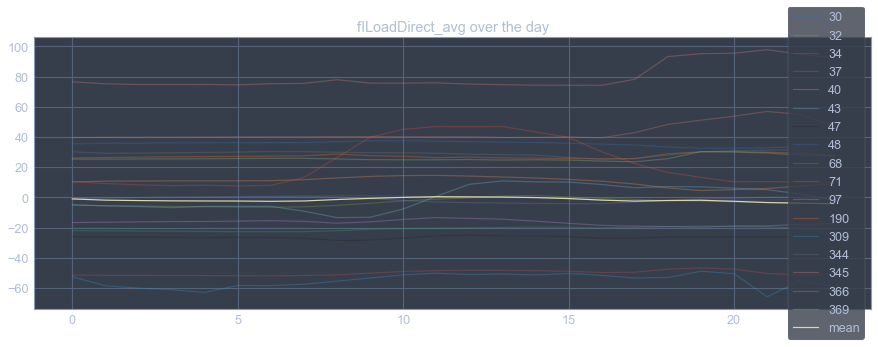

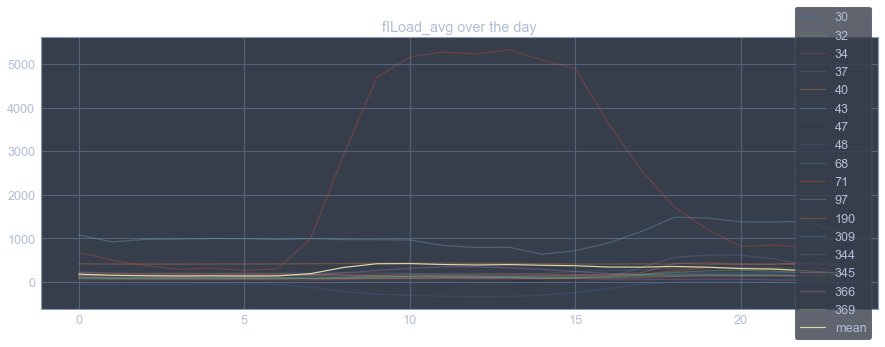

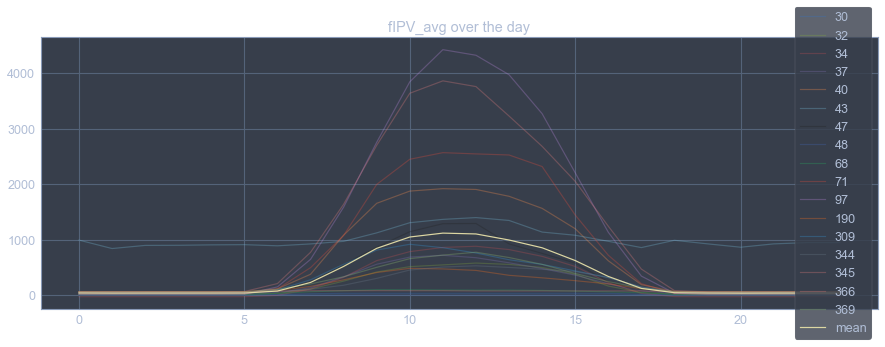

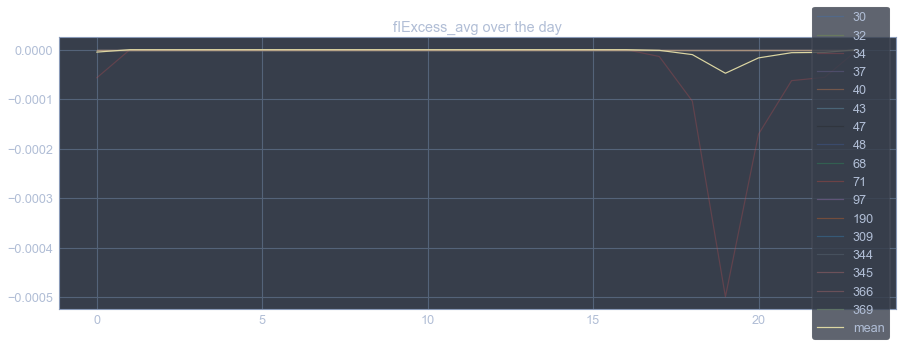

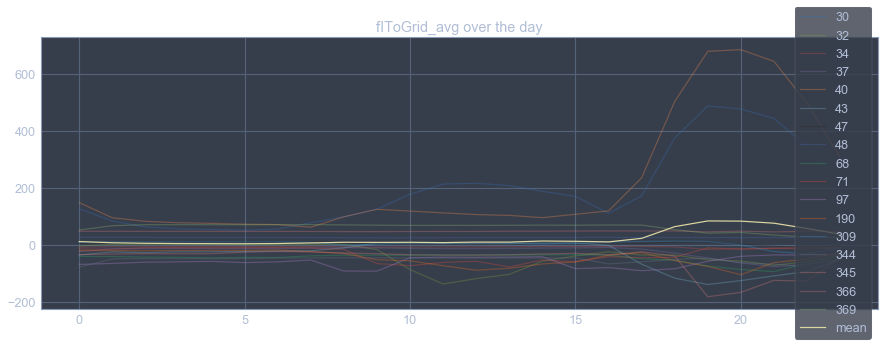

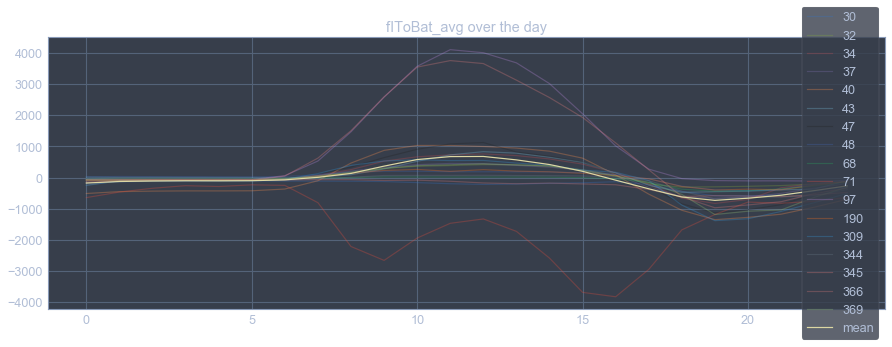

In [5]:
# Visualize voltages over the day
for var in currents:
    plt.figure(figsize=(15, 5))
    for station in stations:
        plt.plot(data_hourly.loc[station].groupby('hour')[var].mean(), label=station, alpha=0.3)
        
    plt.plot(data_hourly.groupby('hour')[var].mean(), label='mean')
    plt.title('{} over the day'.format(var))
    plt.legend(loc='right')
    plt.show()

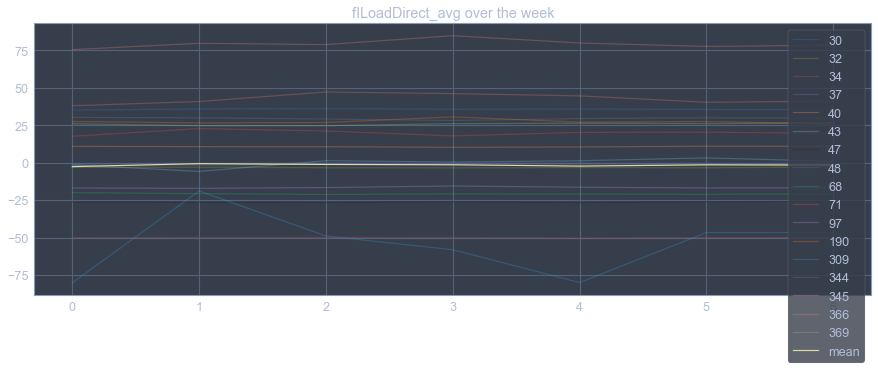

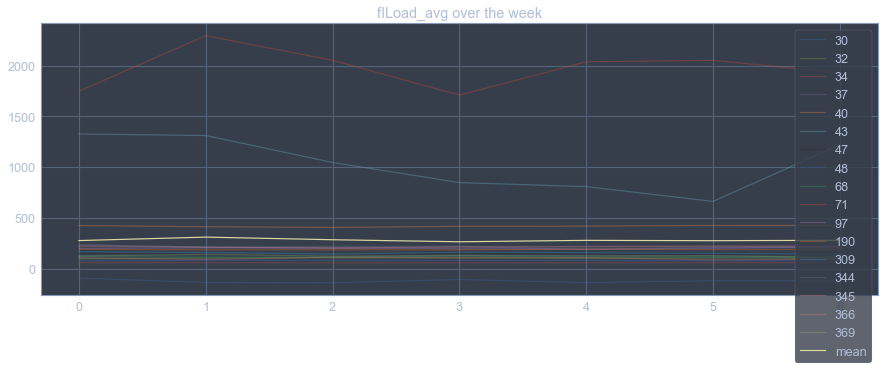

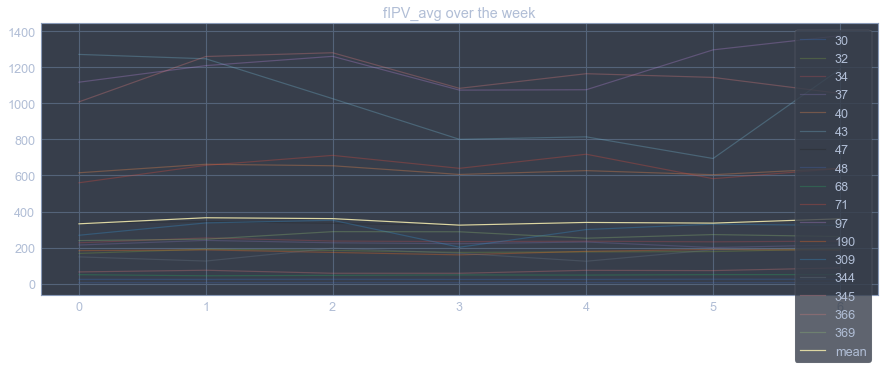

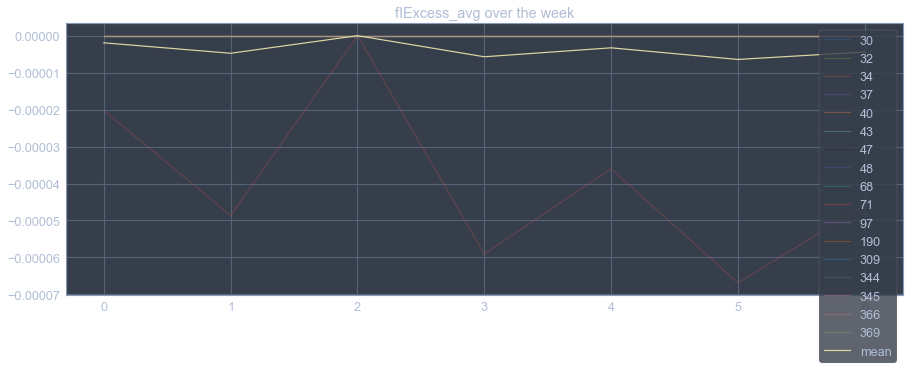

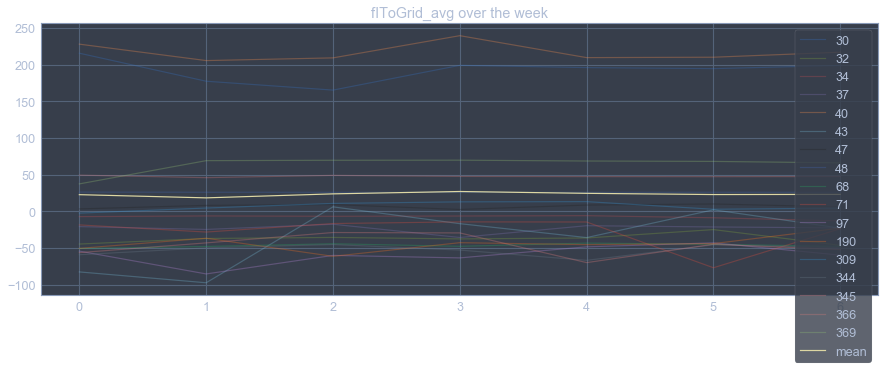

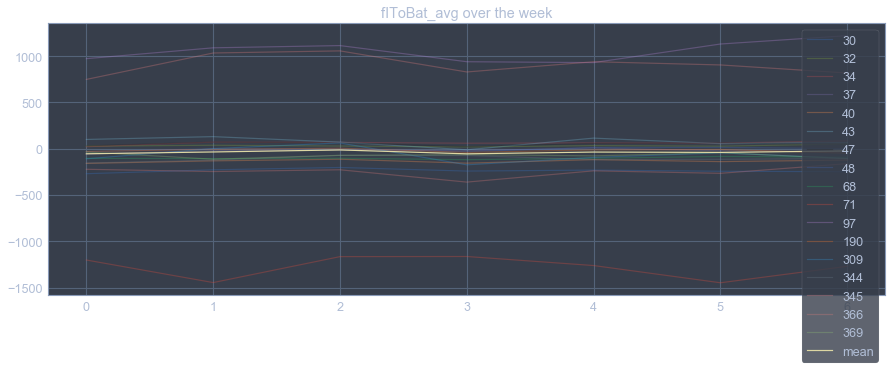

In [6]:
# Visualize voltages over the week
for var in currents:
    plt.figure(figsize=(15, 5))
    for station in stations:
        plt.plot(data_hourly.loc[station].groupby('weekday')[var].mean(), label=station, alpha=0.3)
        
    plt.plot(data_hourly.groupby('weekday')[var].mean(), label='mean')
    plt.title('{} over the week'.format(var))
    plt.legend()
    plt.show()

KeyError: 'month'

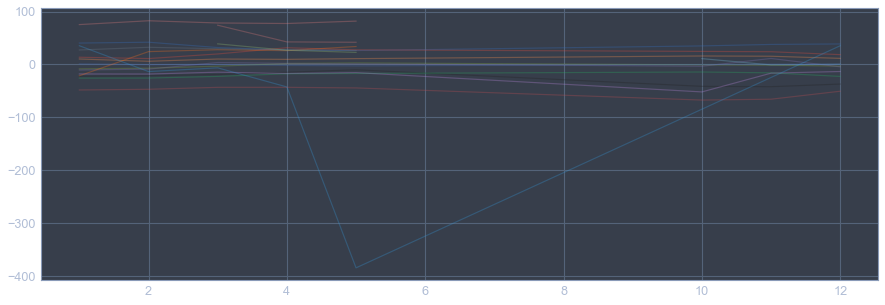

In [7]:
# Visualize voltages over the year
for var in currents:
    plt.figure(figsize=(15, 5))
    for station in stations:
        plt.plot(data_hourly.loc[station].groupby('month')[var].mean(), label=station, alpha=0.3)
        
    plt.plot(data_hourly[var].groupby('month').mean(), label='mean')
    plt.title('{} over the year'.format(var))
    plt.legend(loc='right')
    plt.show()

In [ ]:
for var in currents:
    plt.figure(figsize=(15, 5))
    for station in stations:
        plt.hist(data_hourly.loc[station, var].dropna().values, bins=50, label=str(station), alpha=0.7)
        
    plt.title('Distribution of {}'.format(var))
    plt.legend(loc='right')
    plt.show()

In [ ]:
for var in currents:
    plt.figure(figsize=(15, 5))
    for station in stations:
        plt.plot(data_hourly.loc[station, var].iloc[:1000].values, label=station)
        
    plt.title('{} over the series'.format(var))
    plt.legend(loc='right')
    plt.show()

### Exploration ideas
1. - How much energy doesn't get used because of the battery being full and nobody buying energy?

In [ ]:
data['fILoad_avg'].groupby('solbox_id').sum()

In [ ]:
data['fIExcess_avg'].groupby('solbox_id').sum()

In [ ]:
#1. - How much energy doesn't get used because of the battery being full and nobody buying energy?
data['fIExcess_avg'].groupby('solbox_id').sum() / data['fILoad_avg'].groupby('solbox_id').sum()

In [ ]:
## Modelling